In [3]:
library(readxl)  #for excel sheet read system
library(DBI)  #for Reading Data from SQLite database
library(dbplyr)  #SQL Database queries functions
library(RSQLite)  #RSQL Database queries functions
library(RPostgres) # RPostgres Database functions
library(tidyverse)  #most of our tidyverse functions 
library(scales)  #for labeling comma function and log scales?
library(RColorBrewer)  #color palette (includes color-blind options)
library(svglite)  #to save svg files
library(repr)  #ggplot visualization + options(repr.plot.width=8, repr.plot.height=7)
library(lubridate) #convert different time/date formatss

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::ident()  masks dbplyr::ident()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::sql()    masks dbplyr::sql()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




ERROR: Error in library(svglite): there is no package called ‘svglite’


In [4]:
data <- read_excel("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls")
data

New names:
• `` -> `...2`


Data Set Characteristics: Multivariate,...2,Attribute Information:
<chr>,<lgl>,<chr>
Number of Instances: 403,NA,"STG (The degree of study time for goal object materails),"
Area: Education,NA,SCG (The degree of repetition number of user for goal object materails)
Attribute Characteristics: Real,NA,STR (The degree of study time of user for related objects with goal object)
Number of Attributes: 5,NA,LPR (The exam performance of user for related objects with goal object)
Associated Tasks: Classification,NA,PEG (The exam performance of user for goal objects)
NA,NA,UNS (The knowledge level of user)
Class Distribution,NA,NA
Very Low: 50,NA,NA
Low:129,NA,NA


In [5]:
training <- read_csv("knowledge_training_data.csv") %>%
select("STG", "SCG", "STR", "LPR", "PEG", "UNS") 

training

New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.000,0.00,0.00,0.00,very_low
0.08,0.080,0.10,0.24,0.90,High
0.06,0.060,0.05,0.25,0.33,Low
0.10,0.100,0.15,0.65,0.30,Middle
0.08,0.080,0.08,0.98,0.24,Low
0.09,0.150,0.40,0.10,0.66,Middle
0.10,0.100,0.43,0.29,0.56,Middle
0.15,0.020,0.34,0.40,0.01,very_low
0.20,0.140,0.35,0.72,0.25,Low


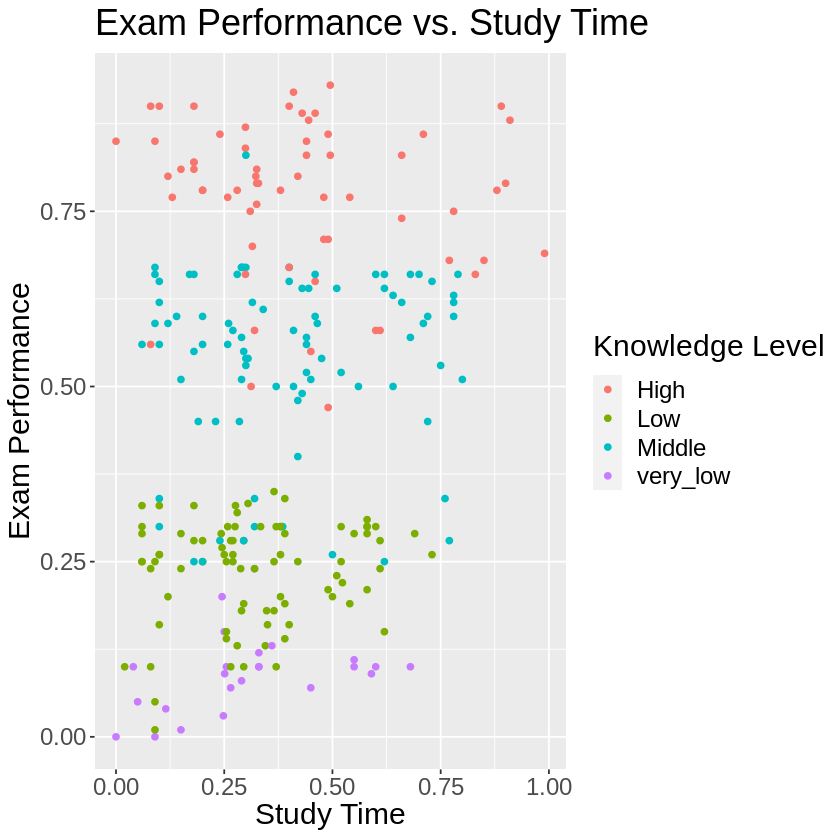

In [16]:
training_plot <- training |>
ggplot(aes(x = STG, y = PEG, color = UNS)) +
geom_point() +
labs(x = "Study Time", y = "Exam Performance", color = "Knowledge Level", title = "Exam Performance vs. Study Time") +
theme(text = element_text(size=18))
training_plot